In [1]:
import multiprocessing
import scipy.optimize as opt
multiprocessing.set_start_method('fork')
from numpy import array
import matplotlib.pyplot as plt

In [2]:
from basic_functionalities import *
import bjmm_mo
import mo
import bm_depth_4
import bm_depth_2
import bm_plus_depth_4
import bjmm
import mmt
import bjmm_tmto
import mmt_tmto

In [3]:
def optimize(time,num_params,constraints):
    start = r(0.001,0.01,num_params)
    bounds = [(0, 1)]*num_params
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    return result

def set_env(module, rate):
    module.k = lambda x : rate
    module.w = lambda x : Hi(1-rate)

def get_data(module):
    time        = module.time
    constraints = module.constraints
    num_vars    = module.num_vars
    return time, constraints, num_vars

def parallel():
    time, constraints, num_vars= get_data(module)
    return optimize(time,num_vars,constraints)

# finds minimum running time for chosen module and given rate k
# if specified memory will be restricted to mem
def find_minimum_for_rate(k , mem=-1):
    set_env(module,k)
    
    count=0
    minval=1
    data=None
    if mem != -1:
        module.constraints.append({ 'type' : 'ineq',   'fun' : module.inject(lambda x : mem-module.memory(x)) }, )
    while count<maxiter:
        candidates=[]
        with multiprocessing.Pool(PROCESSES) as pool:
            params = range(PROCESSES)
            results = [pool.apply_async(parallel) for p in range(PROCESSES*elements_per_process)]
            for i in results:
                candidates.append(i.get())
        for i in candidates:
            if i is None:
                continue
            if time(i.x)<minval and i.success:
                minval=time(i.x)
                data=i.copy()
            count+=1
    if mem !=-1:
        _ = module.constraints.pop()
    return data


## Customize here

In [46]:
# Set module and threads/proccesses used for running the optimization
# Each thread runs the optimization ``elements_per_process`` many times 
# Note that the optimization has to be run multiple times to ensure the 
# true global minimum is found, hence ``PROCESSES*elements_per_process`` 
# should be large enough

module = mmt_tmto
PROCESSES = 4
elements_per_process=3

time,constraints, num_vars= get_data(module)
memory=module.memory
maxiter=PROCESSES*elements_per_process


In [47]:
#Example: finds optimal parameters / running time for rate 0.42
data=find_minimum_for_rate(0.5)
x=module.set_vars(*data["x"])
module.time(x)

## Computing Optimal Time for Different Rates

In [49]:
#create list with optimum for all rates
k=0.01
Lfd=[]
while k<1:
    if int(k*100)%10==0:
        print(k)
    data=find_minimum_for_rate(k)
    Lfd.append([k,data])
    k+=0.01

0.09999999999999999
0.10999999999999999
0.20000000000000004
0.3000000000000001
0.4000000000000002
0.5000000000000002
0.6000000000000003
0.7000000000000004
0.8000000000000005
0.9000000000000006


In [50]:
#extract time and memory lists from Lfd
Ltime=[]
Lmem=[]
for i in Lfd:
    if i[1] is not None:
        set_env(module,i[0])
        x=module.set_vars(*(i[1]['x']))
        Ltime.append([i[0],time(x)])
        Lmem.append([i[0],memory(x)])

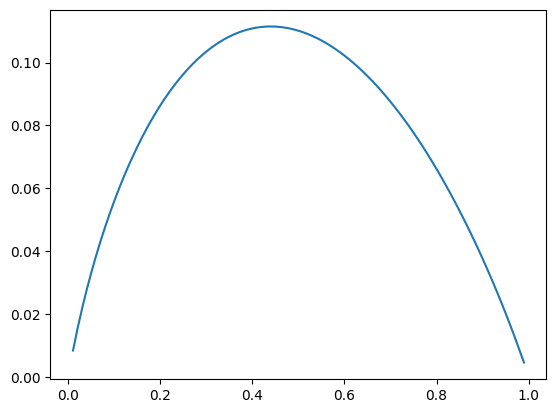

In [52]:
x,y=zip(*Ltime)
plt.plot(x,y)

## Computing Time-Memory Trade-Offs

In [53]:
rate = 0.5
def compute_tradeoff():
    """
    Returns list including optimizer results under increasing memory constraints
    """
    L=[]
    for i in range(25):
        mem = i*0.005 if i !=0 else 1e-6
        data =find_minimum_for_rate(rate,mem=mem)
        L.append(data)
    return L

In [54]:
def extract_tradeoff(L):
    """
    Returns time-memory trade-off list given an output of the compute_trade_off list, i.e., a list with [Time, Memory] for increasing memory, Time is the best time obtained under restricted memory
    """
    Ltm=[]
    for i in L:
        if i == None:
            continue
        set_env(module,rate)
        x=module.set_vars(*(i['x']))
        Ltm.append([memory(x),time(x)])
    return Ltm

In [55]:
L = compute_tradeoff()


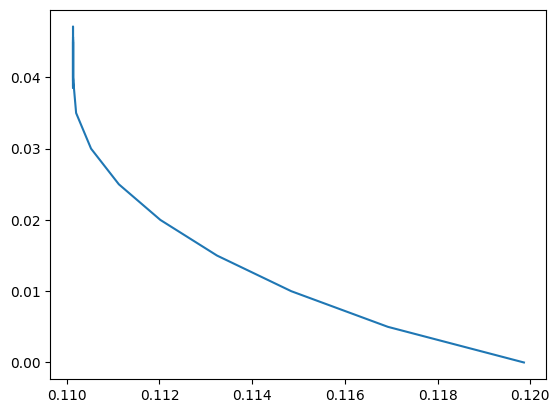

In [57]:
Ltm=extract_tradeoff(L)
x,y=zip(*Ltm)
plt.plot(y,x)